# Fase 2: Clasificación de la ejecución del movimiento

Este Notebook tiene como objetivo principal crear un pipeline que clasifique los gestos realizados como *correctos* o *incorrectos*. Además, aborda los siguientes aspectos clave:

**Caracterización previa de los movimientos**

Se determinan los ángulos de distintas articulaciones en función del gesto que esté realizando el paciente. Por ejemplo, al detectar una flexión del hombro derecho, se calculan los ángulos relacionados específicamente con ese brazo.

**Aprendizaje automático explicativo**

Se incorpora un análisis explicativo del modelo, destacando las variables que tienen mayor influencia en las decisiones del modelo sobre el conjunto de datos completo.


<div style="text-align: center;">
<img src="../Imagenes/gestures.png" width="500"/>
</div>

**1. Importar librerías**

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions as fn
import numpy as np

# scikit-learn (ML en python)
## Procesar el dataset
from sklearn.model_selection import LeaveOneGroupOut # LeavePGroupsOut
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Evaluación de los modelos
from sklearn.metrics import *

## Hiperparametrizacion
from sklearn.model_selection import RandomizedSearchCV

# Class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN

## Seleccion de variables
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance

# Explicacion 
from sklearn import tree # visualizar dtree
import shap

# Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

# Suprimir warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

KeyboardInterrupt: 

pip3 install ipywidgets --user



**2. Importar datos**

In [2]:
# Dataframe de los datos en bruto
df_raw = pd.read_csv('../Resultados/raw_pacientes.csv', dtype=object)
df_raw

SubjectID GestureLabel GestureName RepetitionNumber CorrectLabel  \
0             101            0         EFL                1            1   
1             101            0         EFL                1            1   
2             101            0         EFL                1            1   
3             101            0         EFL                1            1   
4             101            0         EFL                1            1   
...           ...          ...         ...              ...          ...   
5206170       307            8         STR                9            1   
5206171       307            8         STR                9            1   
5206172       307            8         STR                9            1   
5206173       307            8         STR                9            1   
5206174       307            8         STR                9            1   

             JointName         3D_X         3D_Y      3D_Z  
0            SpineBase   -0.1028086   0.06965441  2.464606  
1             SpineMid   -0.1026228    0.3837799  2.438919  
2                 Neck   -0.1025293    0.6877351   2.40196  
3                 Head   -0.1190992    0.8358598  2.373549  
4         ShoulderLeft   -0.2826451    0.5525576   2.38421  
...                ...          ...          ...       ...  
5206170  SpineShoulder  -0.05799517    0.5291457  2.422904  
5206171    HandTipLeft    -0.302538   -0.1131345  2.284269  
5206172      ThumbLeft   -0.2783904  -0.06298634  2.269769  
5206173   HandTipRight    0.1525867    -0.136378   2.45287  
5206174     ThumbRight    0.1846331  -0.06777165  2.436065  

[5206175 rows x 9 columns]

**3. Funciones creadas**

In [3]:
# dividir en test y train df_gestures
def split_df_gestures(df:pd.DataFrame, target: str):

    # Selecciona los datos de prueba (varios sujetos)
    test_df = df.loc[(df.SubjectID==102) | (df.SubjectID==105) | (df.SubjectID==201) |
                (df.SubjectID==202) | (df.SubjectID==212) | (df.SubjectID==205) | (df.SubjectID==302)] 

    # Selecciona los datos de entrenamiento excluyendo los mismos sujetos
    train_df = df.loc[(df.SubjectID!=102) & (df.SubjectID!=105)  & (df.SubjectID!=201) &
                    (df.SubjectID!=202) & (df.SubjectID!=212) & (df.SubjectID!=205) & (df.SubjectID!=302) ]
    
    # Caclular porcentajes
    n_total = len(df)
    print(f'Entrenamiento {(len(train_df)*100)/n_total}%. Prueba {(len(test_df)*100)/n_total}%')

    # Separa las características y las etiquetas en el conjunto de entrenamiento
    X_train = train_df.drop([target], axis=1)  
    y_train = pd.DataFrame(train_df[target])   

    # Separa las características y las etiquetas en el conjunto de prueba
    X_test = test_df.drop([target], axis=1)  
    y_test = pd.DataFrame(test_df[target])   

    # Convierte los DataFrames de etiquetas a arrays 1D
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    # Devuelve los conjuntos de entrenamiento y prueba
    return X_train, X_test, y_train, y_test

**4. Caracterización previa de los movimientos y Pipeline**

* ***Malla de hiperparámetros***

In [4]:
param_grid = [
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [2, 3, 5], 
        'classifier__weights': ['uniform', 'distance'], 
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [DecisionTreeClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20, 30]
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [GaussianNB()],
        'classifier__var_smoothing': np.logspace(0, -8, num=100)
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [SVC(probability=True)],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__C': [0.1, 1, 10, 100]
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [200, 300],
        'classifier__max_features': ['sqrt', 'log2']
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [LogisticRegression(max_iter=500)],
        'classifier__C': [0.01, 0.1, 1, 10, 100]
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [MLPClassifier()],
        'classifier__hidden_layer_sizes': [(10,10,10), (10,20,10), (15,25,15)],
        'classifier__activation': ['relu', 'tanh', 'logistic'],
        'classifier__solver': ['adam'],
        'classifier__alpha': [0.0001, 0.001, 0.01, 0.05],
        'classifier__learning_rate': ['constant', 'invscaling', 'adaptive']
    }
]

* ***Bucle para recorrer los gestos***
<small>
1. Caracterización de movimientos: calcular ángulos dependiendo del gesto.
2. Crear pipeline con: técnica de balanceo de datos, selección de características y algoritmo de clasificación
3. Hiperparametrización con RandomSearchCV (con LOGO)
4. Evaluación: F1-score, informe y curva ROC
5. Explicación global: violin plots, visualización de cálculos internos, Permutation Importance y SHAP

</small>

Entrenamiento 76.51821862348179%. Prueba 23.481781376518217%

------------ CLASIFICACION GESTO EFL (Flexión del codo izquierdo) -----------

Pipeline(steps=[('balance_data',
                 SMOTETomek(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=5)),
                ('classifier', SVC(C=1, probability=True))])
F1-score del conjunto de entrenamiento: 0.8835978835978836
Informe de clasificación (conjunto de prueba):
              precision    recall  f1-score   support

           1       0.98      0.82      0.89        51
           2       0.40      0.86      0.55         7

    accuracy                           0.83        58
   macro avg       0.69      0.84      0.72        58
weighted avg       0.91      0.83      0.85        58



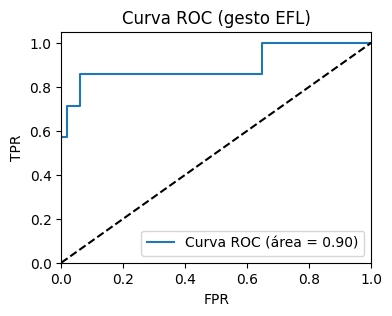

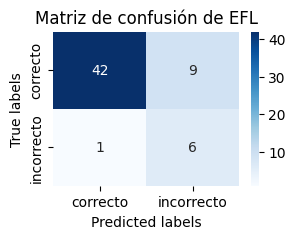

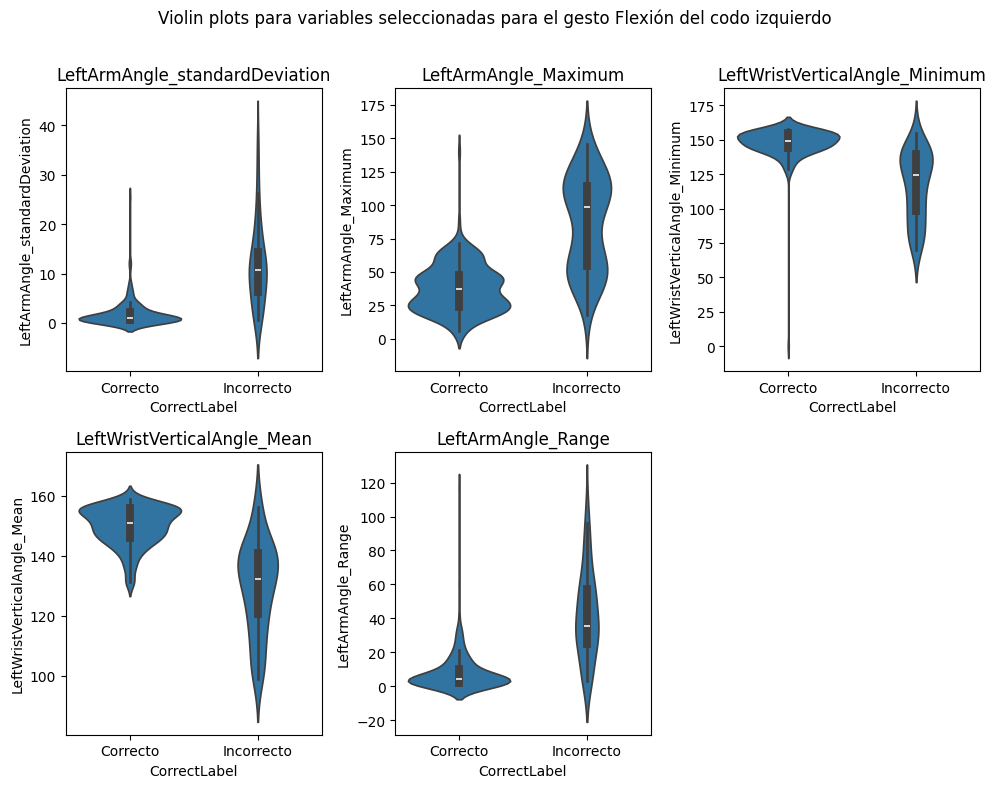

<Figure size 640x480 with 0 Axes>

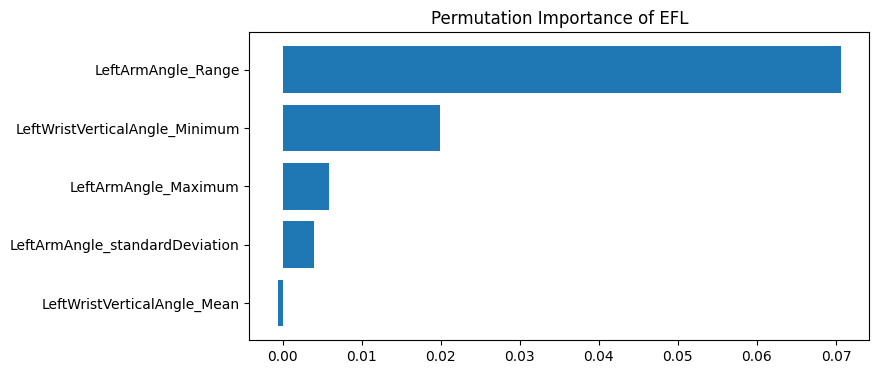

ExactExplainer explainer: 248it [00:48,  4.88it/s]                         


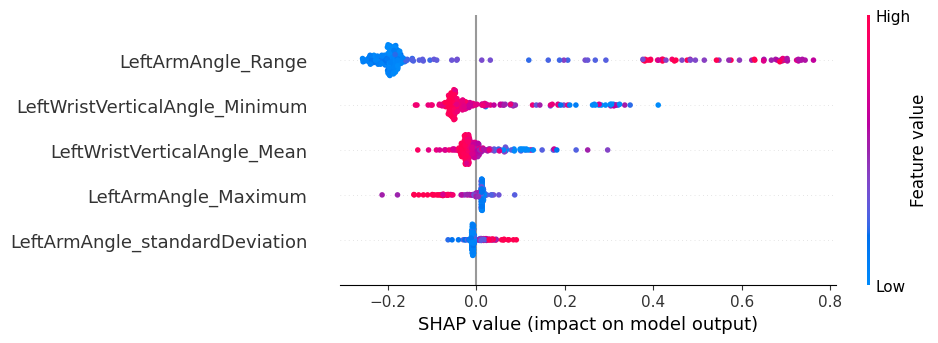

Entrenamiento 71.53558052434457%. Prueba 28.46441947565543%

------------ CLASIFICACION GESTO EFR (Flexión del codo derecho) -----------



C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Pipeline(steps=[('balance_data',
                 SMOTETomek(smote=SMOTE(k_neighbors=4, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=7)),
                ('classifier',
                 MLPClassifier(alpha=0.01, hidden_layer_sizes=(15, 25, 15),
                               learning_rate='adaptive'))])
F1-score del conjunto de entrenamiento: 0.8952879581151832
Informe de clasificación (conjunto de prueba):
              precision    recall  f1-score   support

           1       0.90      1.00      0.95        63
           2       1.00      0.46      0.63        13

    accuracy                           0.91        76
   macro avg       0.95      0.73      0.79        76
weighted avg       0.92      0.91      0.89        76



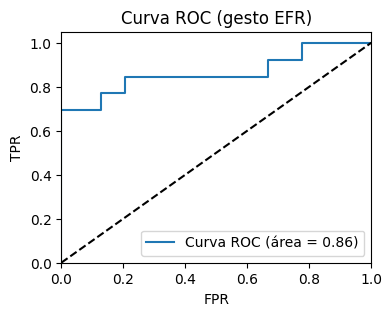

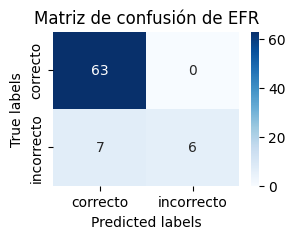

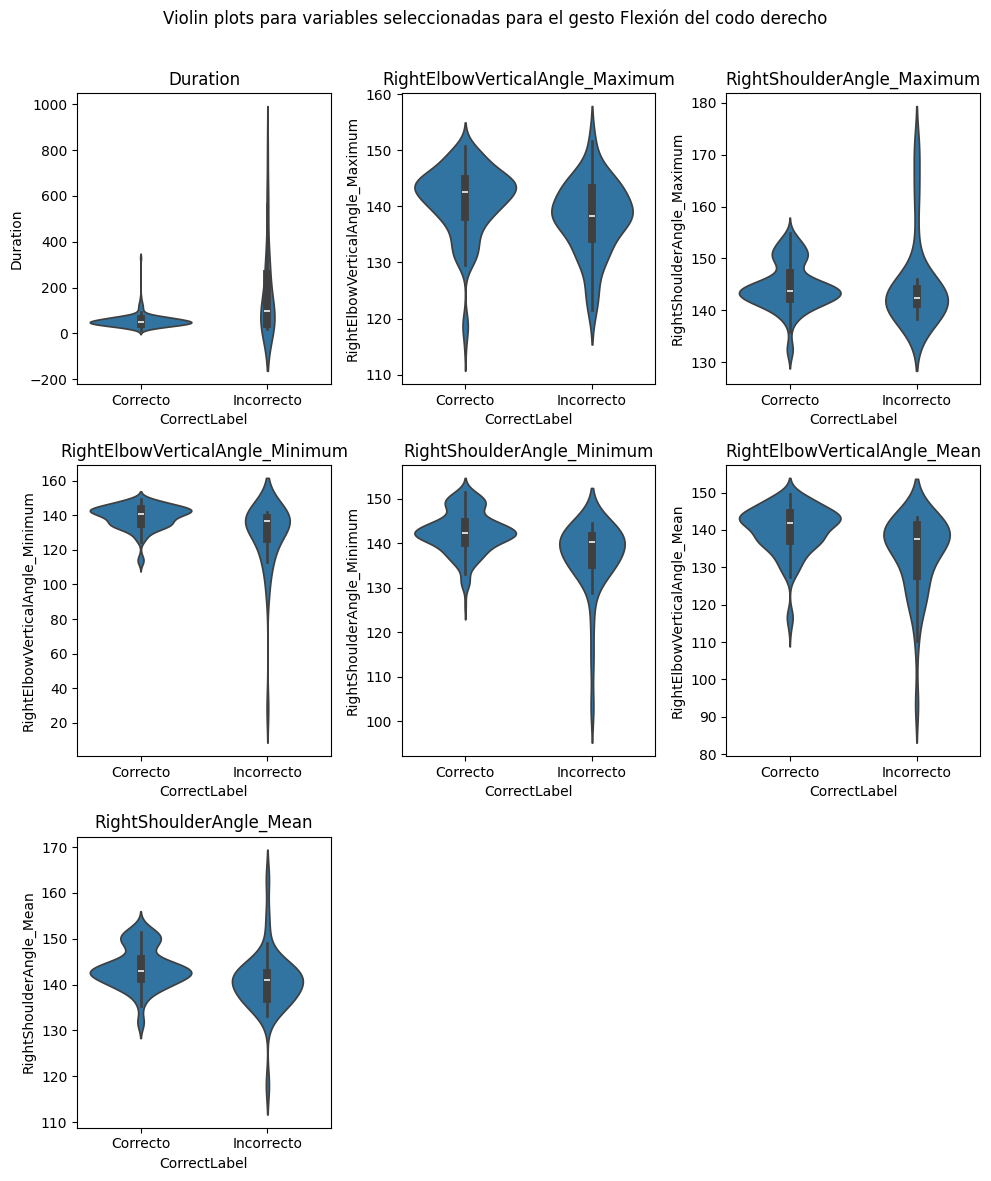

<Figure size 640x480 with 0 Axes>

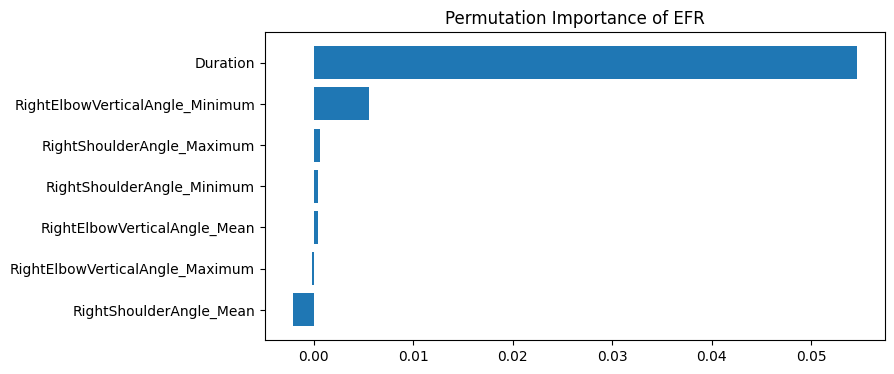

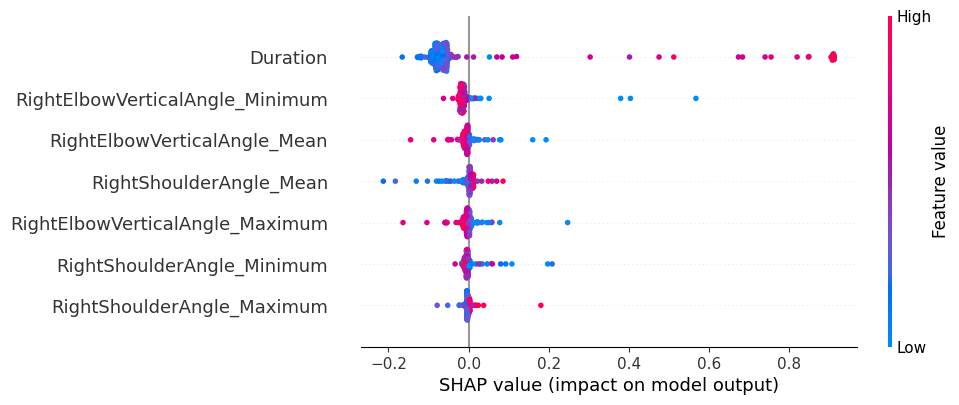

Entrenamiento 74.93036211699165%. Prueba 25.069637883008358%

------------ CLASIFICACION GESTO SFL (Flexión del hombro izquierdo) -----------

Pipeline(steps=[('balance_data',
                 SMOTEENN(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=13)),
                ('classifier', SVC(C=100, kernel='linear', probability=True))])
F1-score del conjunto de entrenamiento: 0.8884758364312267
Informe de clasificación (conjunto de prueba):
              precision    recall  f1-score   support

           1       0.66      0.83      0.73        46
           2       0.75      0.55      0.63        44

    accuracy                           0.69        90
   macro avg       0.70      0.69      0.68        90
weighted avg       0.70      0.69      0.68        90



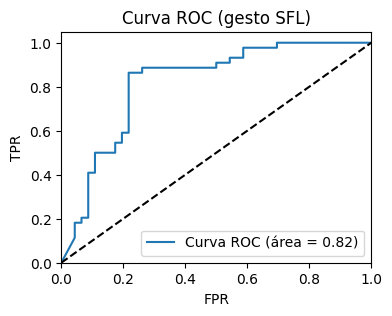

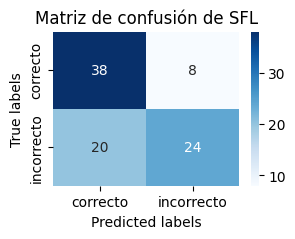

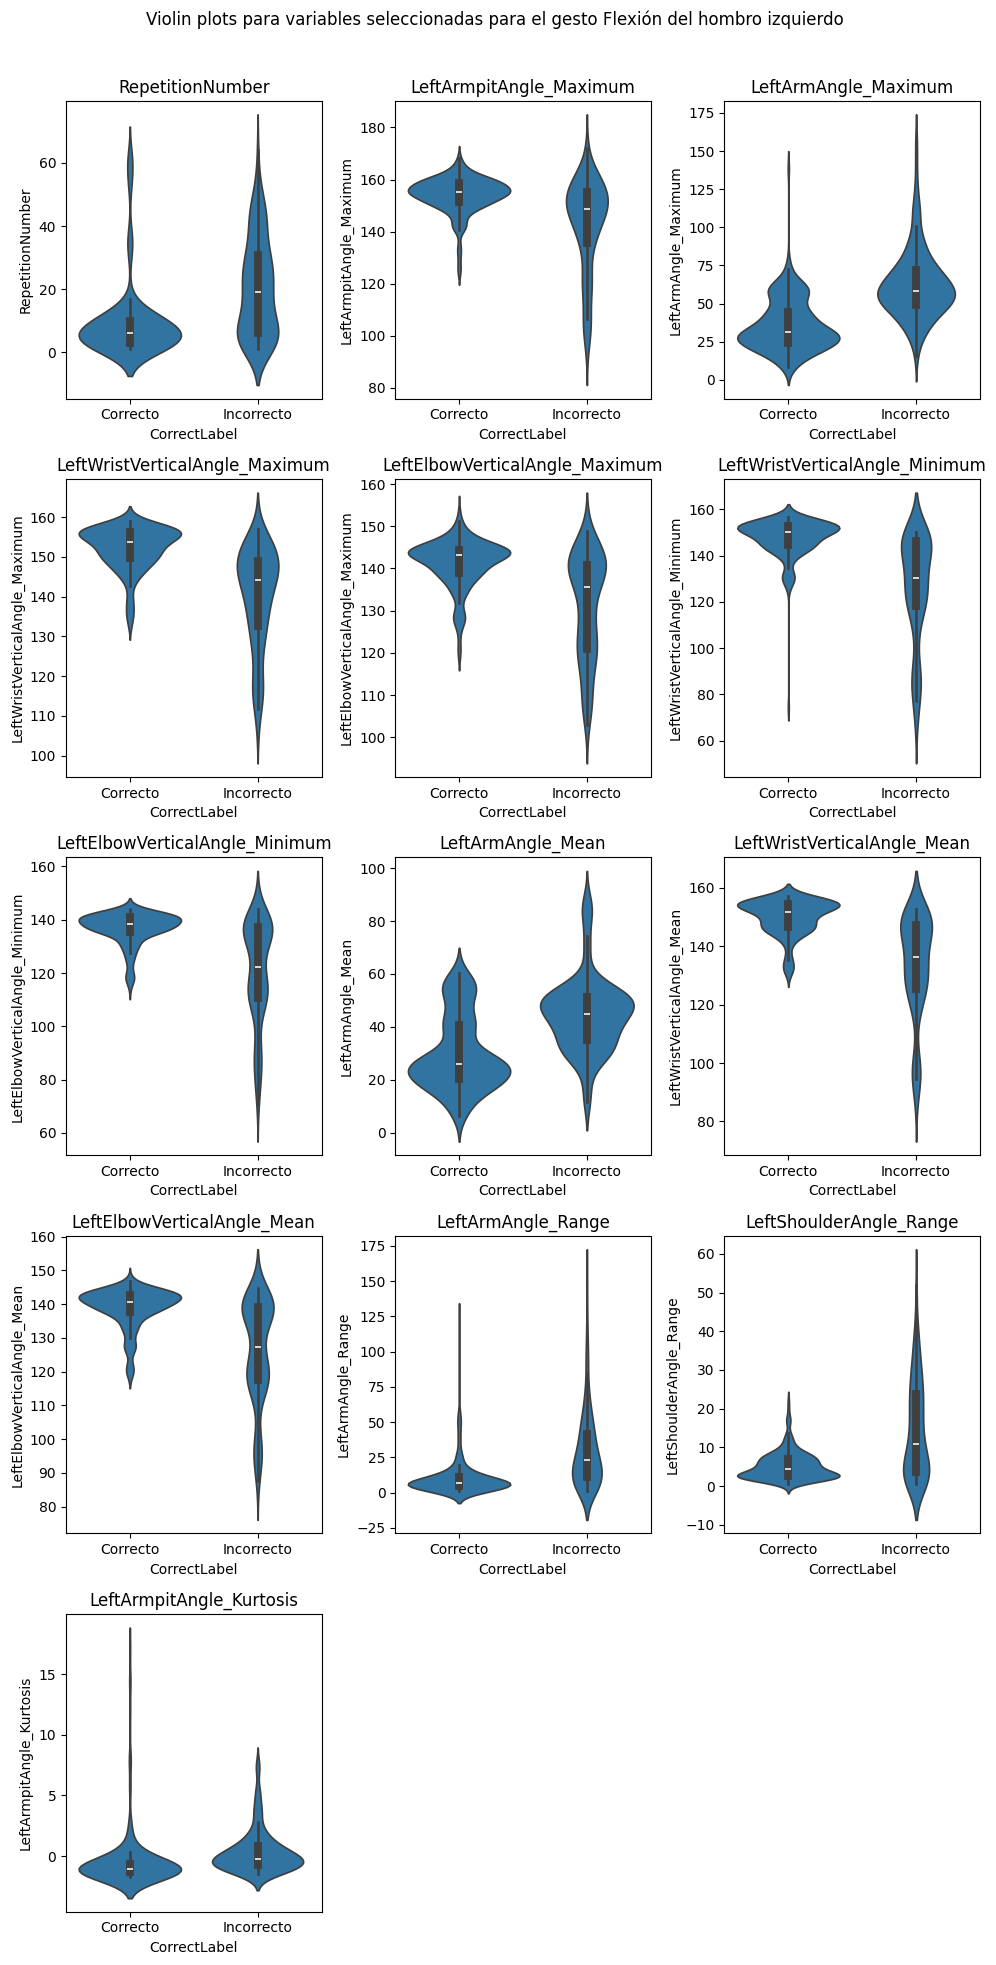

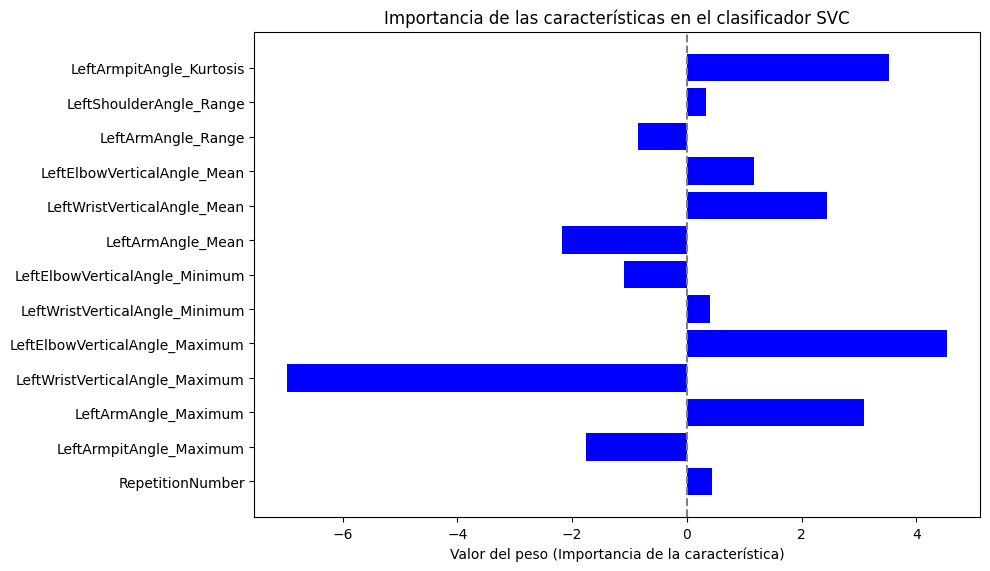

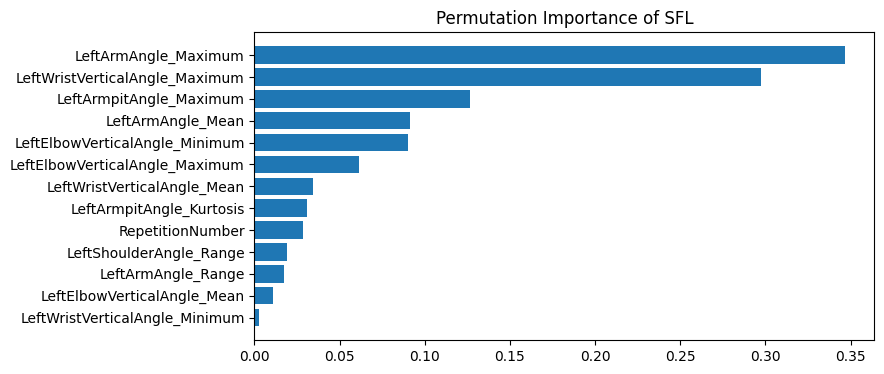

PermutationExplainer explainer: 360it [01:03,  4.75it/s]                         


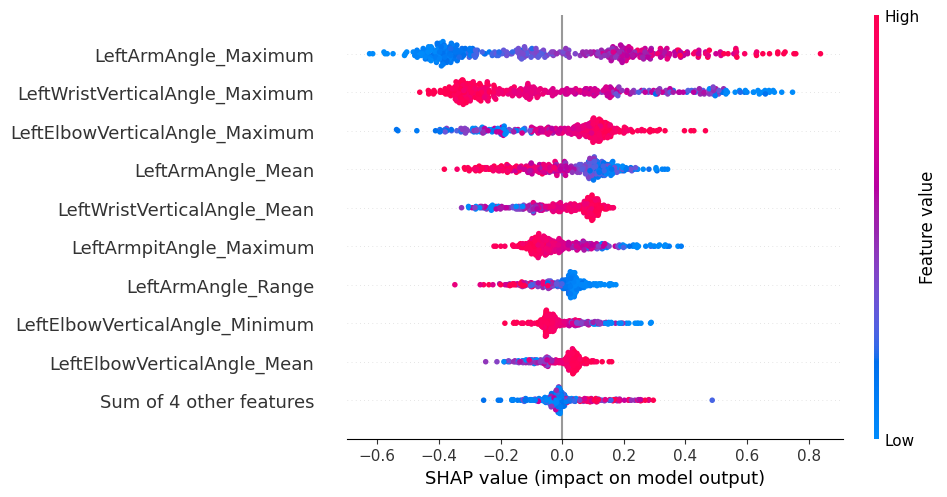

Entrenamiento 79.06976744186046%. Prueba 20.930232558139537%

------------ CLASIFICACION GESTO SFR (Flexión del hombro derecho) -----------



C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Pipeline(steps=[('balance_data',
                 SMOTETomek(smote=SMOTE(k_neighbors=4, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=12)),
                ('classifier', GaussianNB(var_smoothing=0.1873817422860384))])
F1-score del conjunto de entrenamiento: 0.8067226890756303
Informe de clasificación (conjunto de prueba):
              precision    recall  f1-score   support

           1       0.78      0.98      0.87        43
           2       0.89      0.40      0.55        20

    accuracy                           0.79        63
   macro avg       0.83      0.69      0.71        63
weighted avg       0.81      0.79      0.77        63



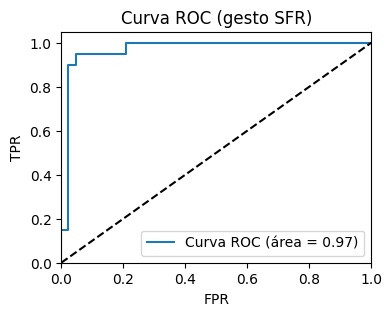

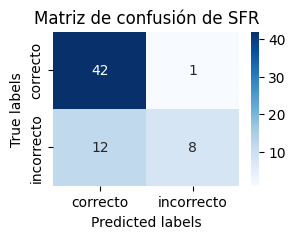

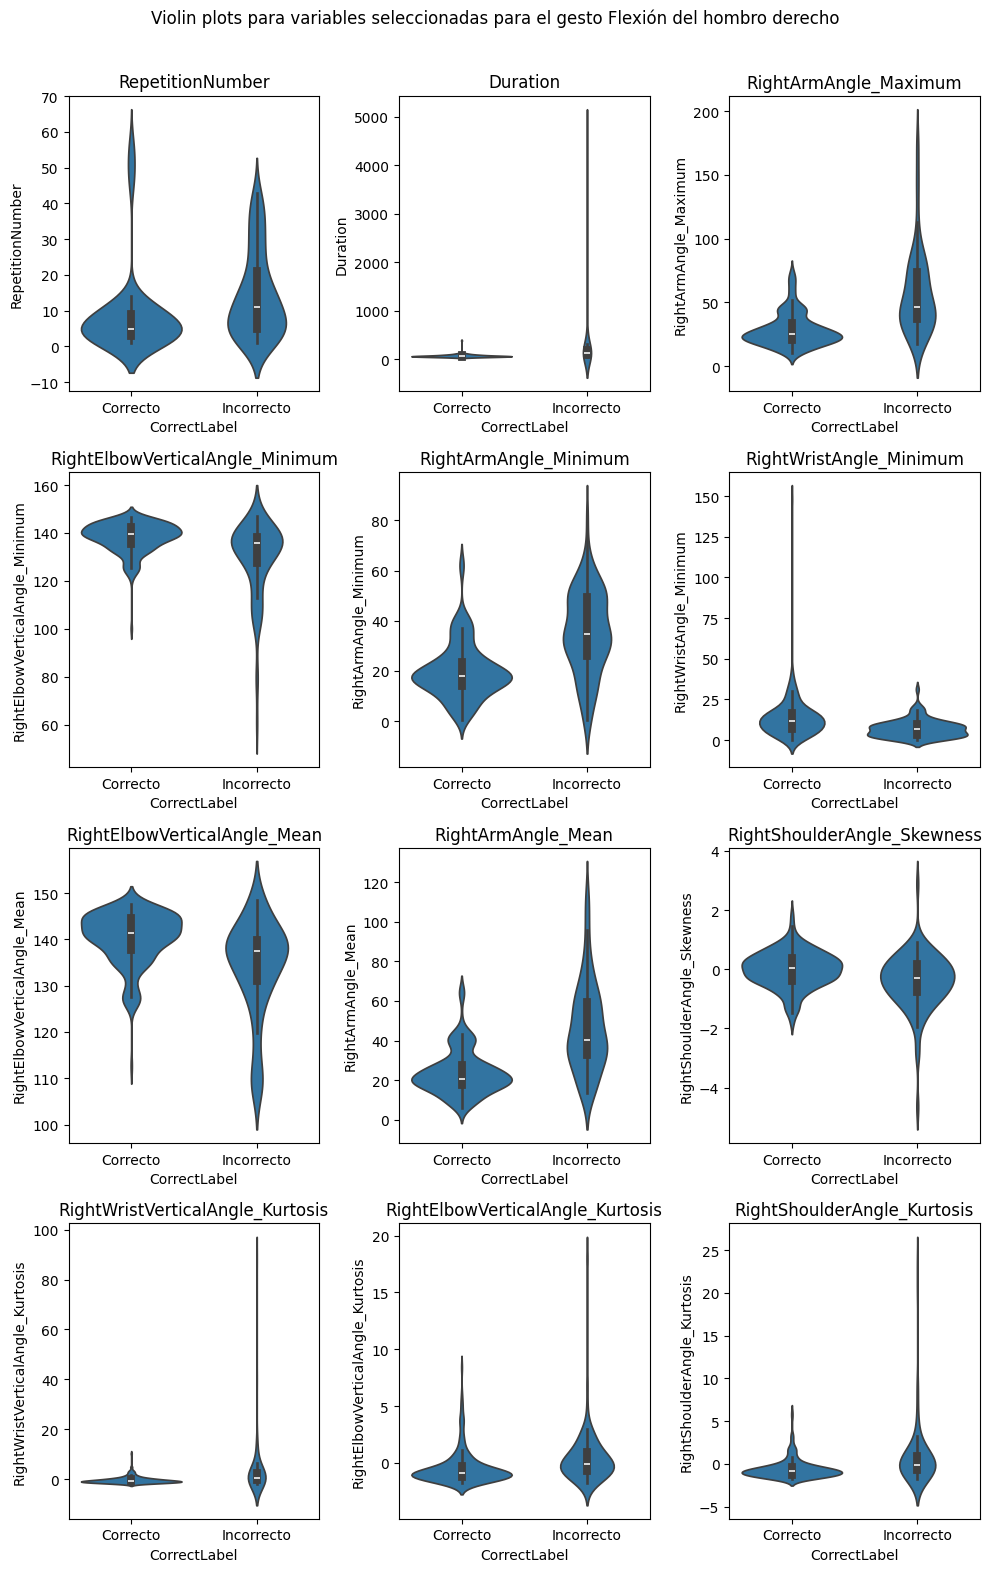

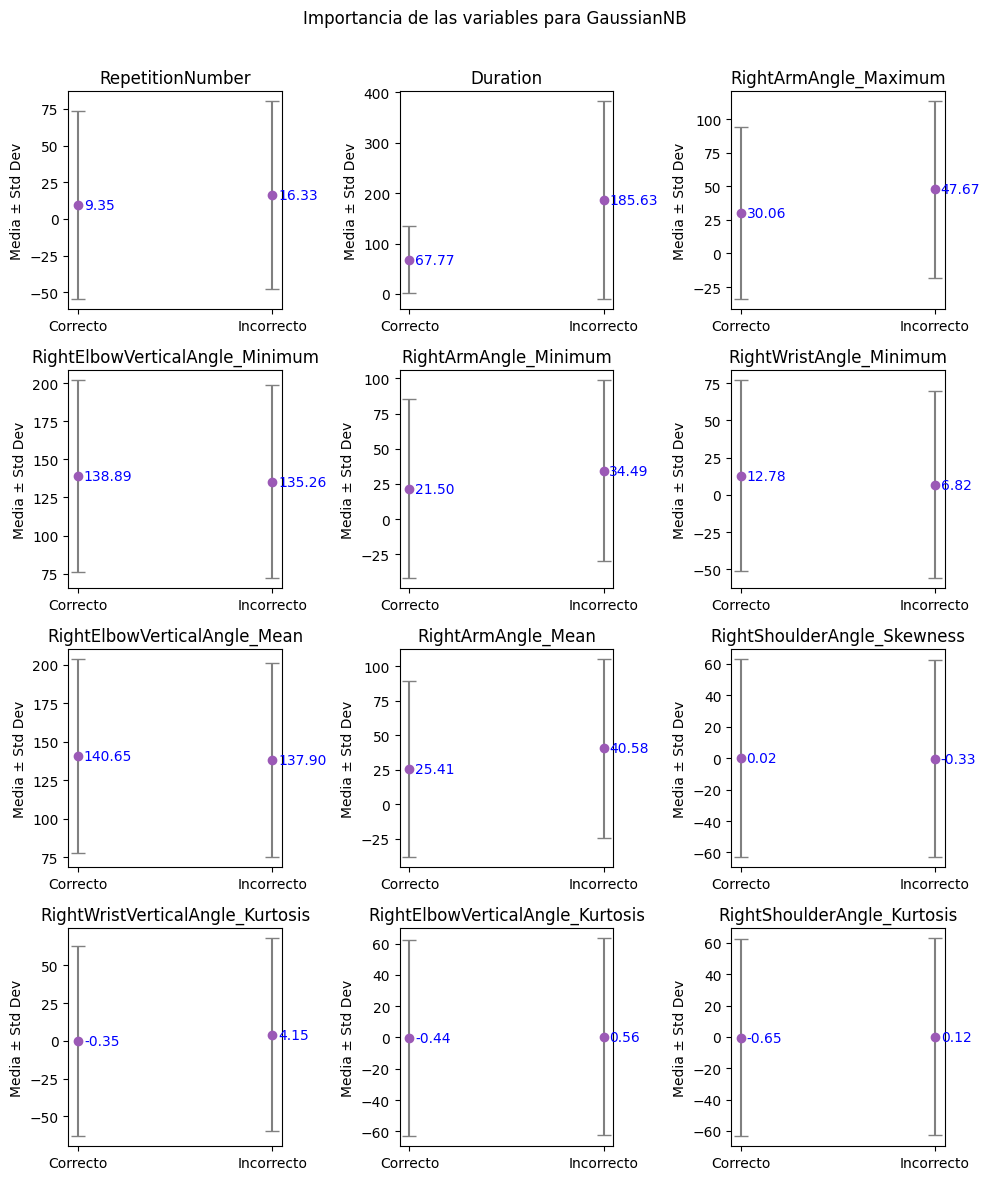

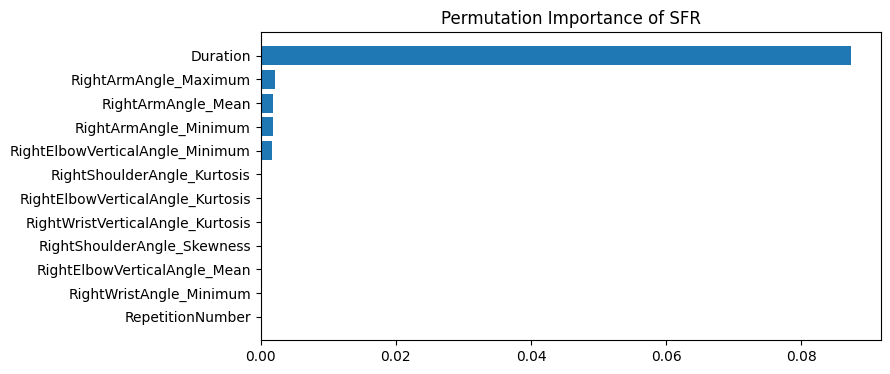

PermutationExplainer explainer: 302it [00:28,  7.43it/s]                         


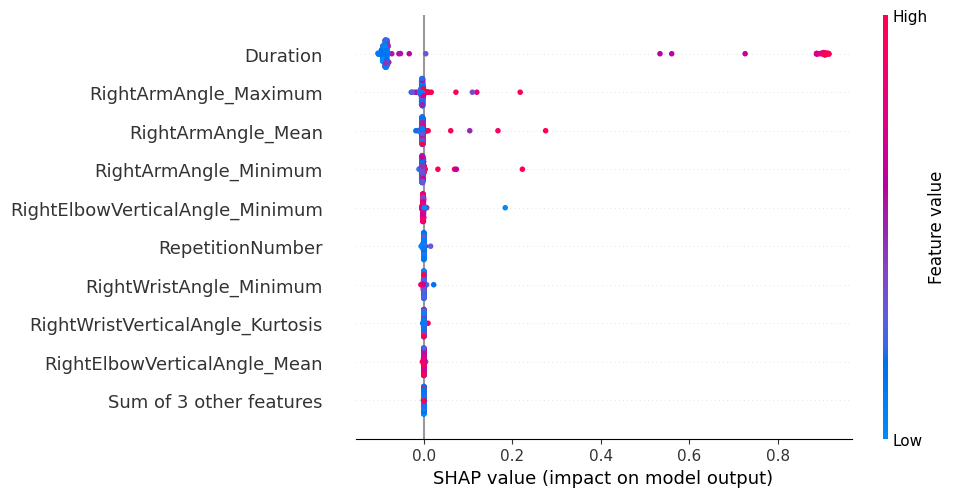

Entrenamiento 66.1596958174905%. Prueba 33.840304182509506%

------------ CLASIFICACION GESTO SAL (Abducción del hombro izquierdo) -----------



C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Pipeline(steps=[('balance_data',
                 SMOTETomek(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=12)),
                ('classifier',
                 MLPClassifier(activation='tanh', alpha=0.01,
                               hidden_layer_sizes=(10, 20, 10)))])
F1-score del conjunto de entrenamiento: 0.7758620689655172
Informe de clasificación (conjunto de prueba):
              precision    recall  f1-score   support

           1       0.88      0.61      0.72        69
           2       0.34      0.70      0.46        20

    accuracy                           0.63        89
   macro avg       0.61      0.65      0.59        89
weighted avg       0.76      0.63      0.66        89



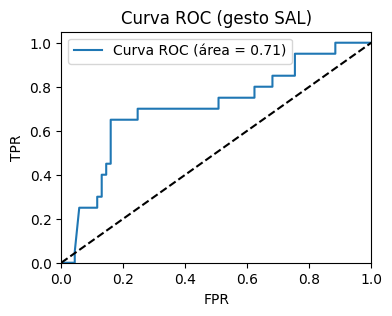

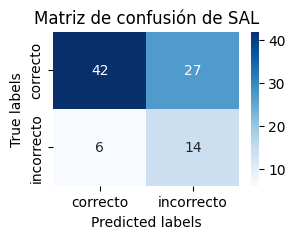

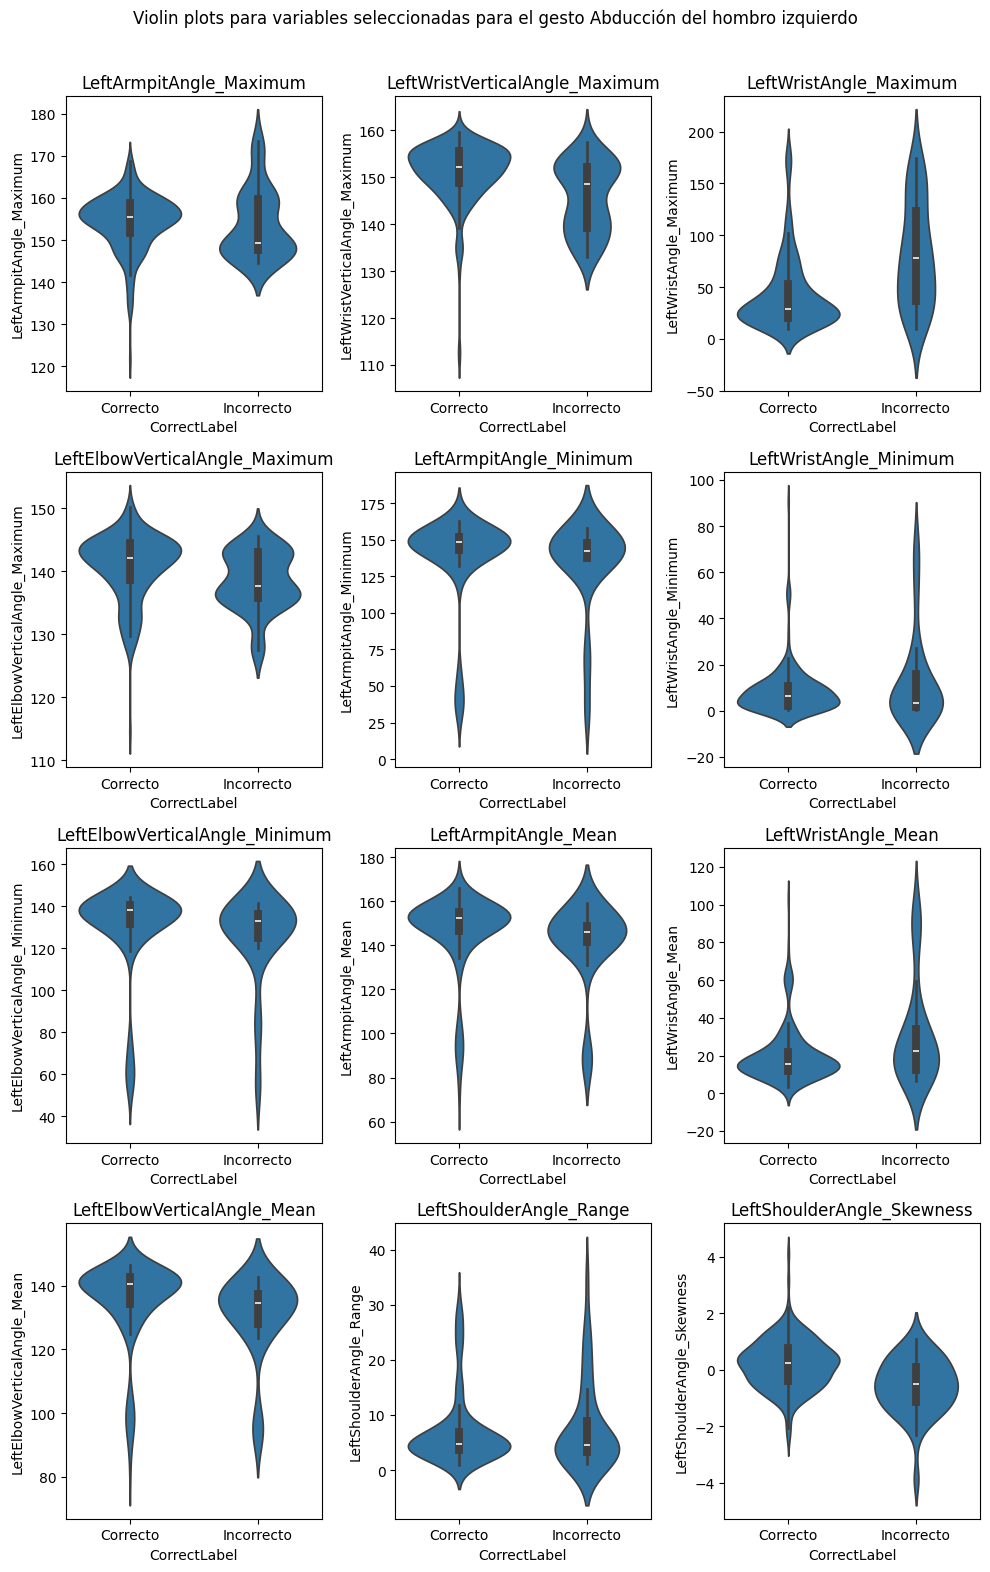

<Figure size 640x480 with 0 Axes>

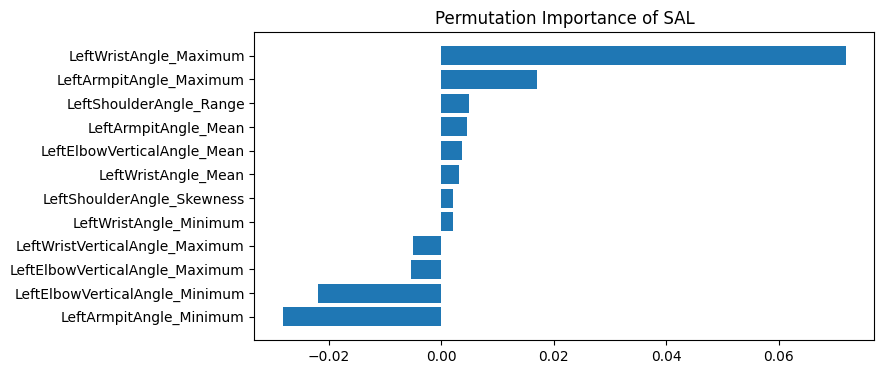

PermutationExplainer explainer: 264it [00:47,  4.40it/s]                         


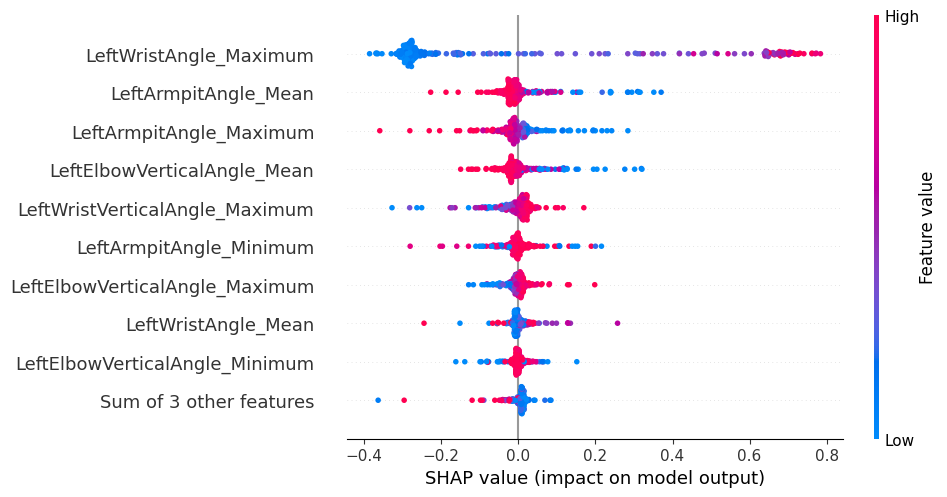

Entrenamiento 79.32489451476793%. Prueba 20.675105485232066%

------------ CLASIFICACION GESTO SAR (Abducción del hombro derecho) -----------



C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Pipeline(steps=[('balance_data',
                 SMOTETomek(smote=SMOTE(k_neighbors=4, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=11)),
                ('classifier',
                 MLPClassifier(hidden_layer_sizes=(10, 20, 10),
                               learning_rate='adaptive'))])
F1-score del conjunto de entrenamiento: 0.8191489361702128
Informe de clasificación (conjunto de prueba):
              precision    recall  f1-score   support

           1       0.84      1.00      0.91        41
           2       0.00      0.00      0.00         8

    accuracy                           0.84        49
   macro avg       0.42      0.50      0.46        49
weighted avg       0.70      0.84      0.76        49



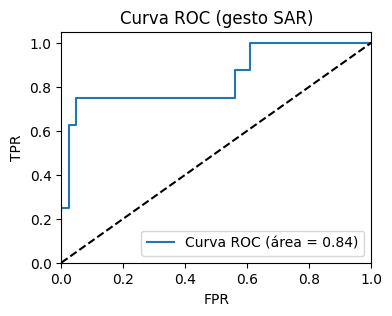

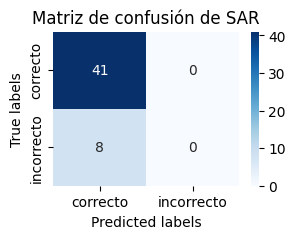

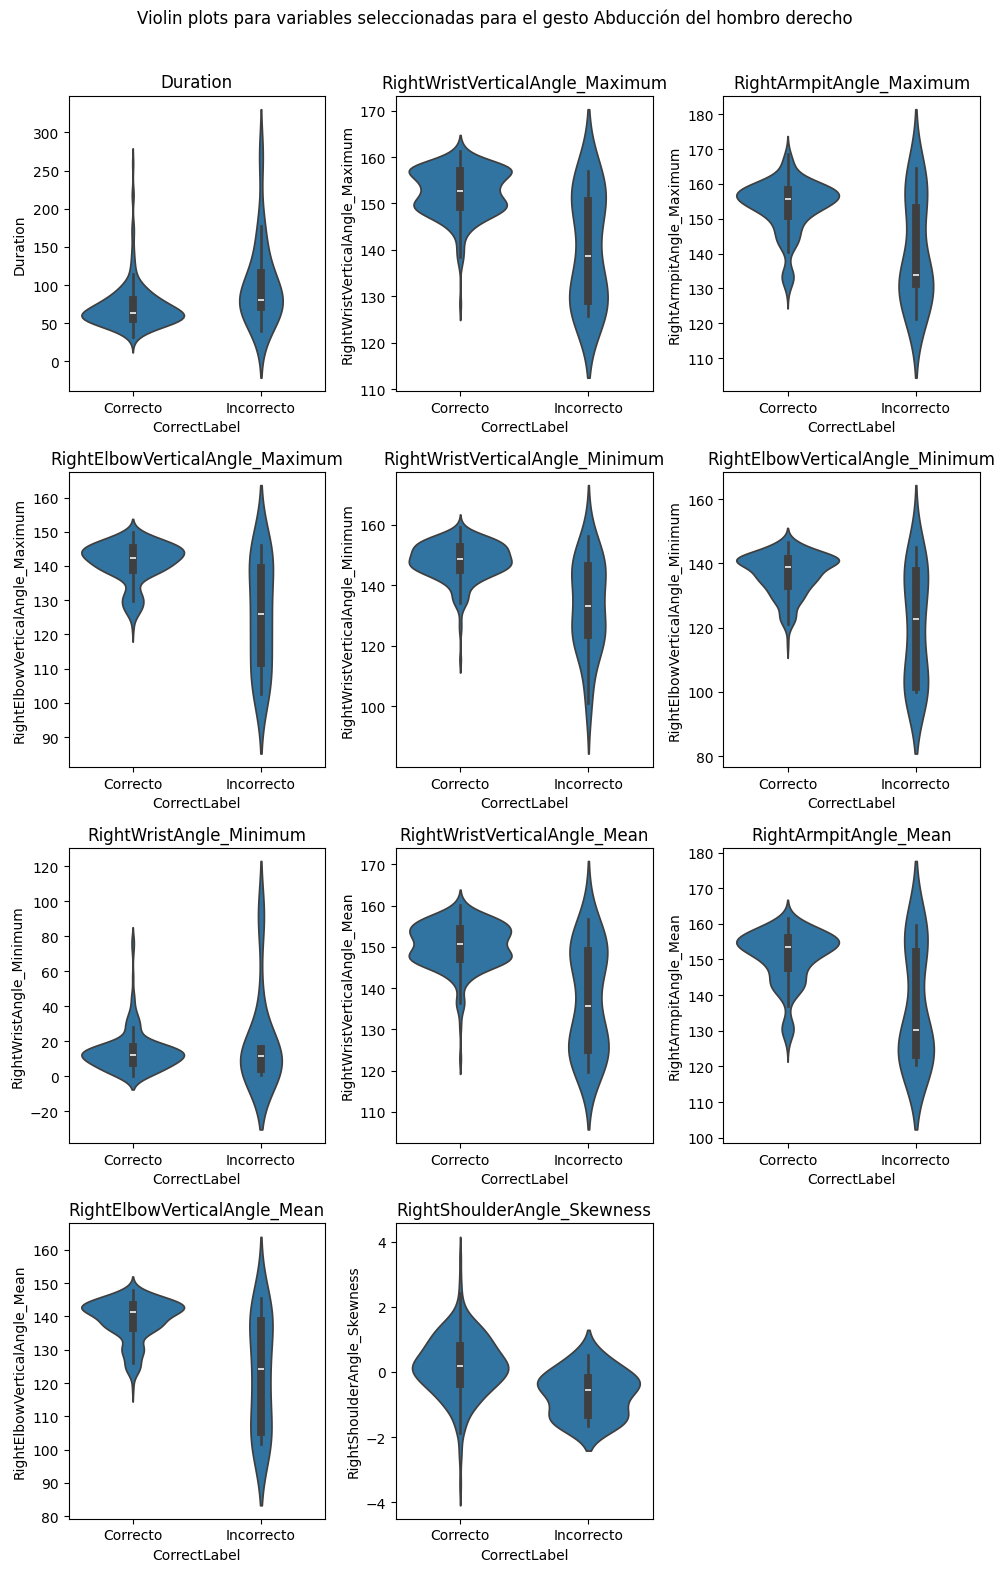

<Figure size 640x480 with 0 Axes>

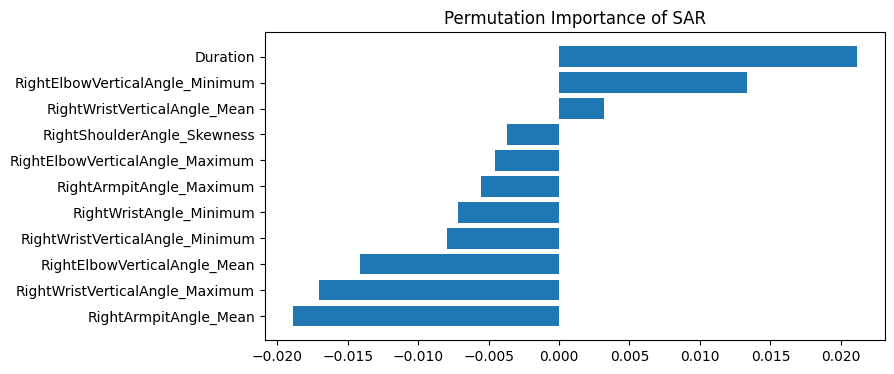

PermutationExplainer explainer: 238it [00:21,  5.48it/s]                         


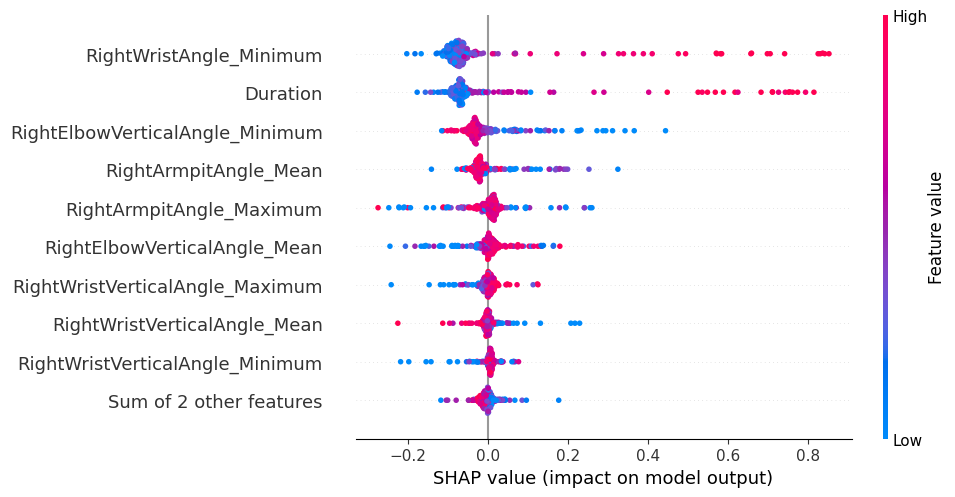

Entrenamiento 79.26829268292683%. Prueba 20.73170731707317%

------------ CLASIFICACION GESTO SFE (Elevación frontal del hombro) -----------

Pipeline(steps=[('balance_data',
                 SMOTEENN(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=5)),
                ('classifier',
                 MLPClassifier(alpha=0.05, hidden_layer_sizes=(15, 25, 15),
                               learning_rate='adaptive'))])
F1-score del conjunto de entrenamiento: 0.9692307692307692
Informe de clasificación (conjunto de prueba):
              precision    recall  f1-score   support

           1       0.95      0.93      0.94        41
           2       0.73      0.80      0.76        10

    accuracy                           0.90        51
   macro avg       0.84      0.86      0.85        51
weighted avg       0.91      0.90      0.90        51



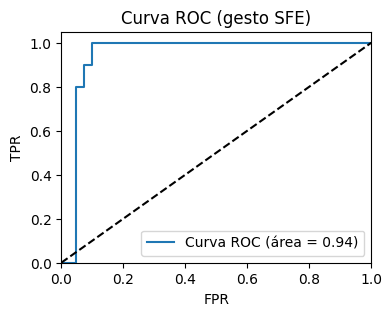

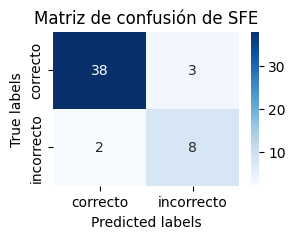

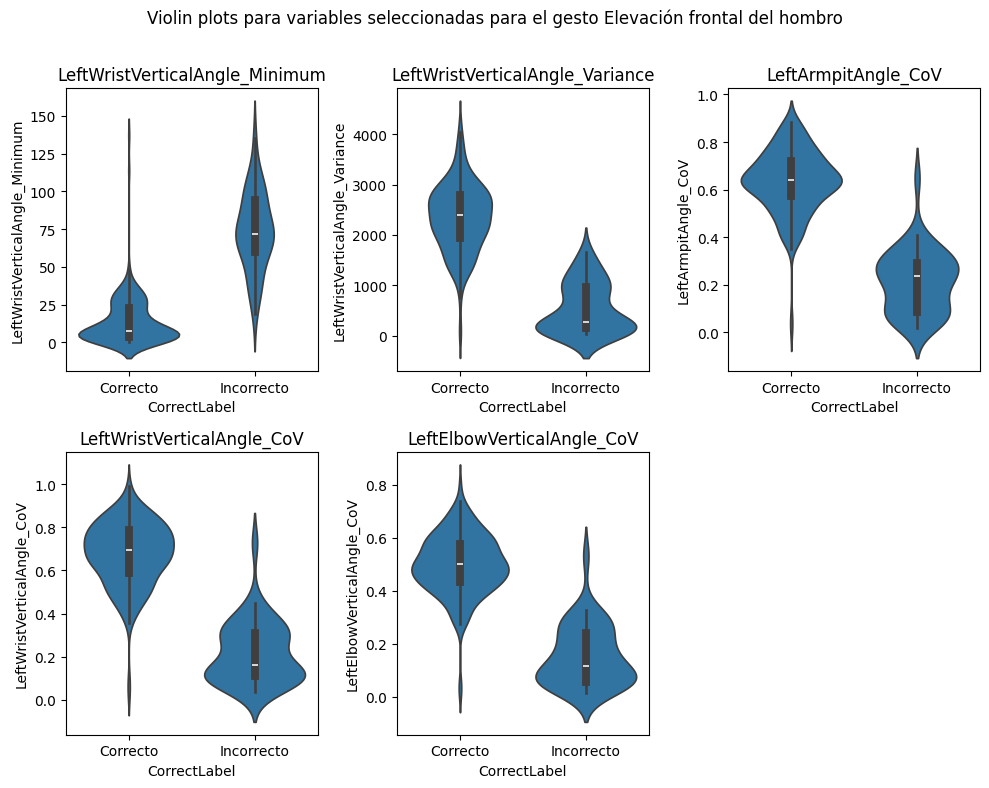

<Figure size 640x480 with 0 Axes>

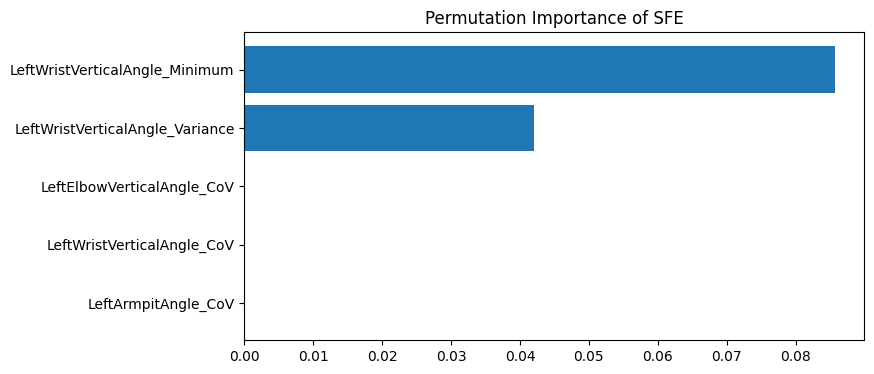

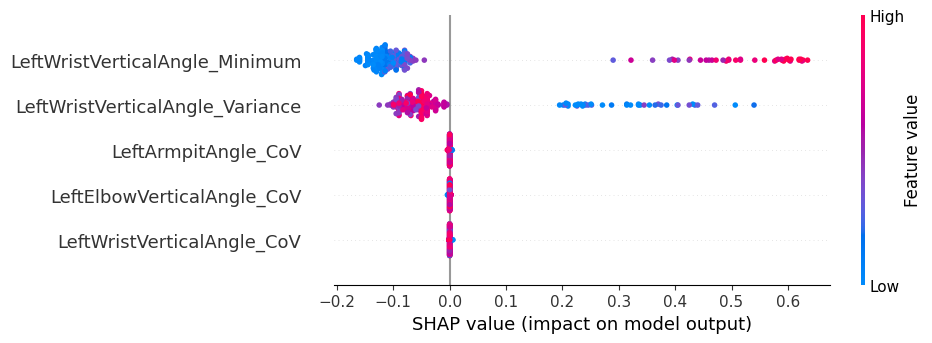

Entrenamiento 73.89558232931726%. Prueba 26.104417670682732%

------------ CLASIFICACION GESTO STL (Toque lateral izquierdo) -----------

Pipeline(steps=[('balance_data',
                 SMOTETomek(smote=SMOTE(k_neighbors=4, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=5)),
                ('classifier',
                 MLPClassifier(activation='logistic', alpha=0.05,
                               hidden_layer_sizes=(15, 25, 15),
                               learning_rate='invscaling'))])
F1-score del conjunto de entrenamiento: 0.8858695652173914
Informe de clasificación (conjunto de prueba):
              precision    recall  f1-score   support

           1       0.97      1.00      0.98        57
           2       1.00      0.75      0.86         8

    accuracy                           0.97        65
   macro avg       0.98      0.88      0.92        65
weighted avg       0.97      0.97      0.97        65



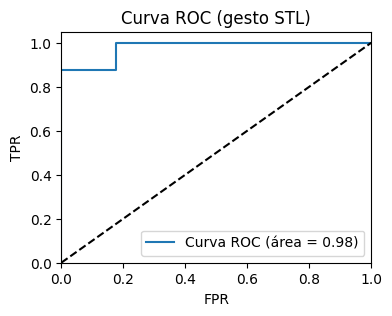

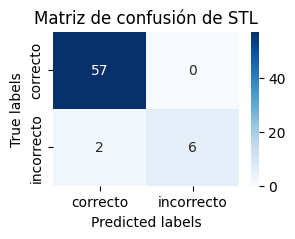

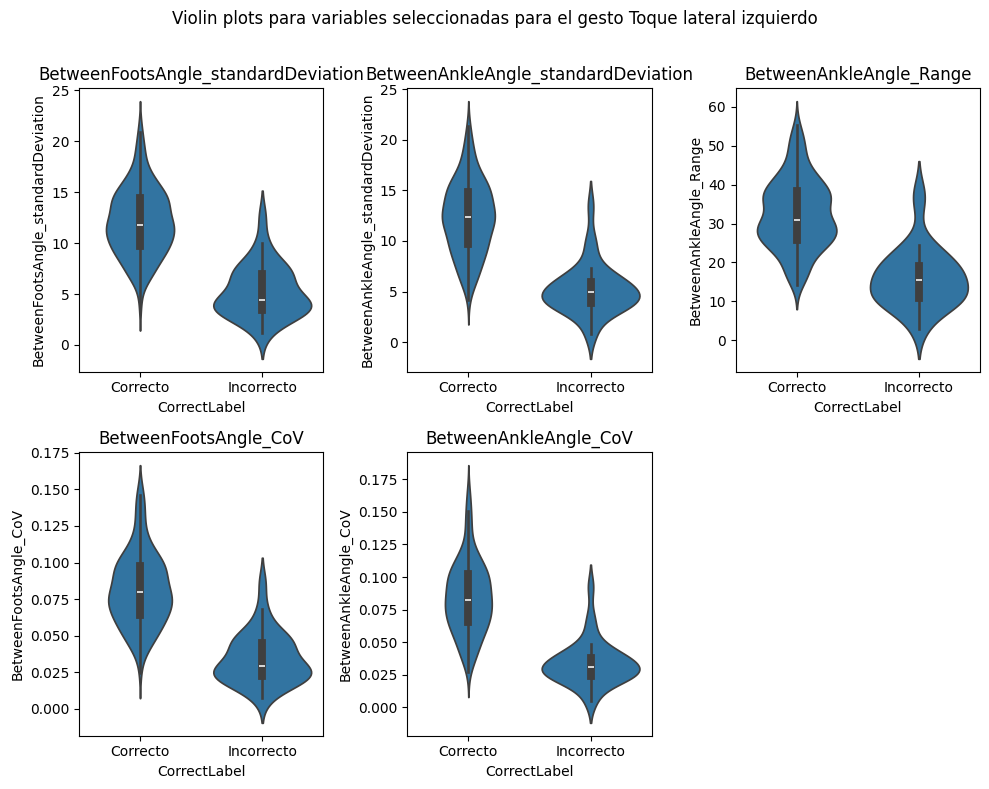

<Figure size 640x480 with 0 Axes>

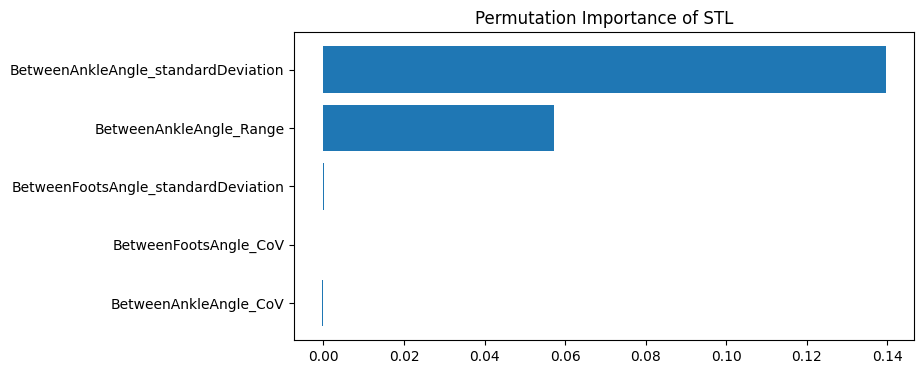

ExactExplainer explainer: 250it [00:11,  3.23it/s]                         


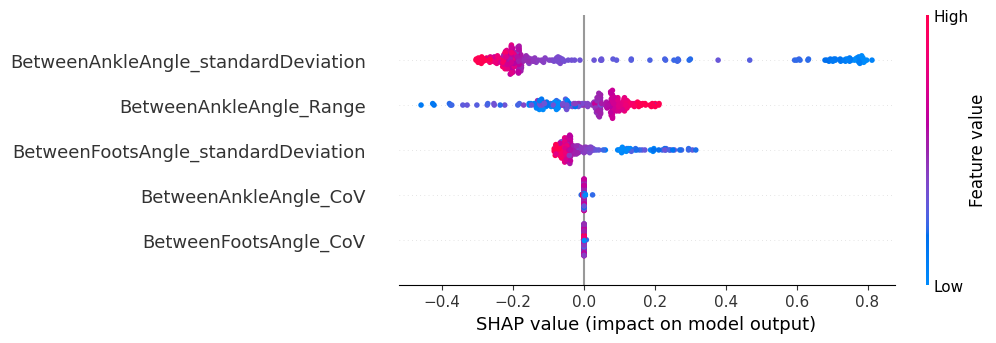

Entrenamiento 68.21428571428571%. Prueba 31.785714285714285%

------------ CLASIFICACION GESTO STR (Toque lateral derecho) -----------

Pipeline(steps=[('balance_data',
                 SMOTETomek(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=12)),
                ('classifier',
                 GaussianNB(var_smoothing=8.697490026177817e-07))])
F1-score del conjunto de entrenamiento: 0.806282722513089
Informe de clasificación (conjunto de prueba):
              precision    recall  f1-score   support

           1       1.00      0.96      0.98        80
           2       0.75      1.00      0.86         9

    accuracy                           0.97        89
   macro avg       0.88      0.98      0.92        89
weighted avg       0.97      0.97      0.97        89



C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


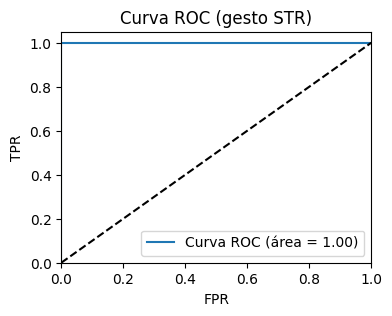

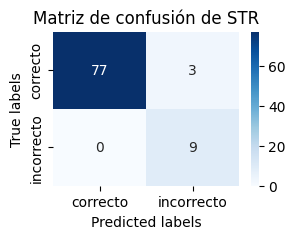

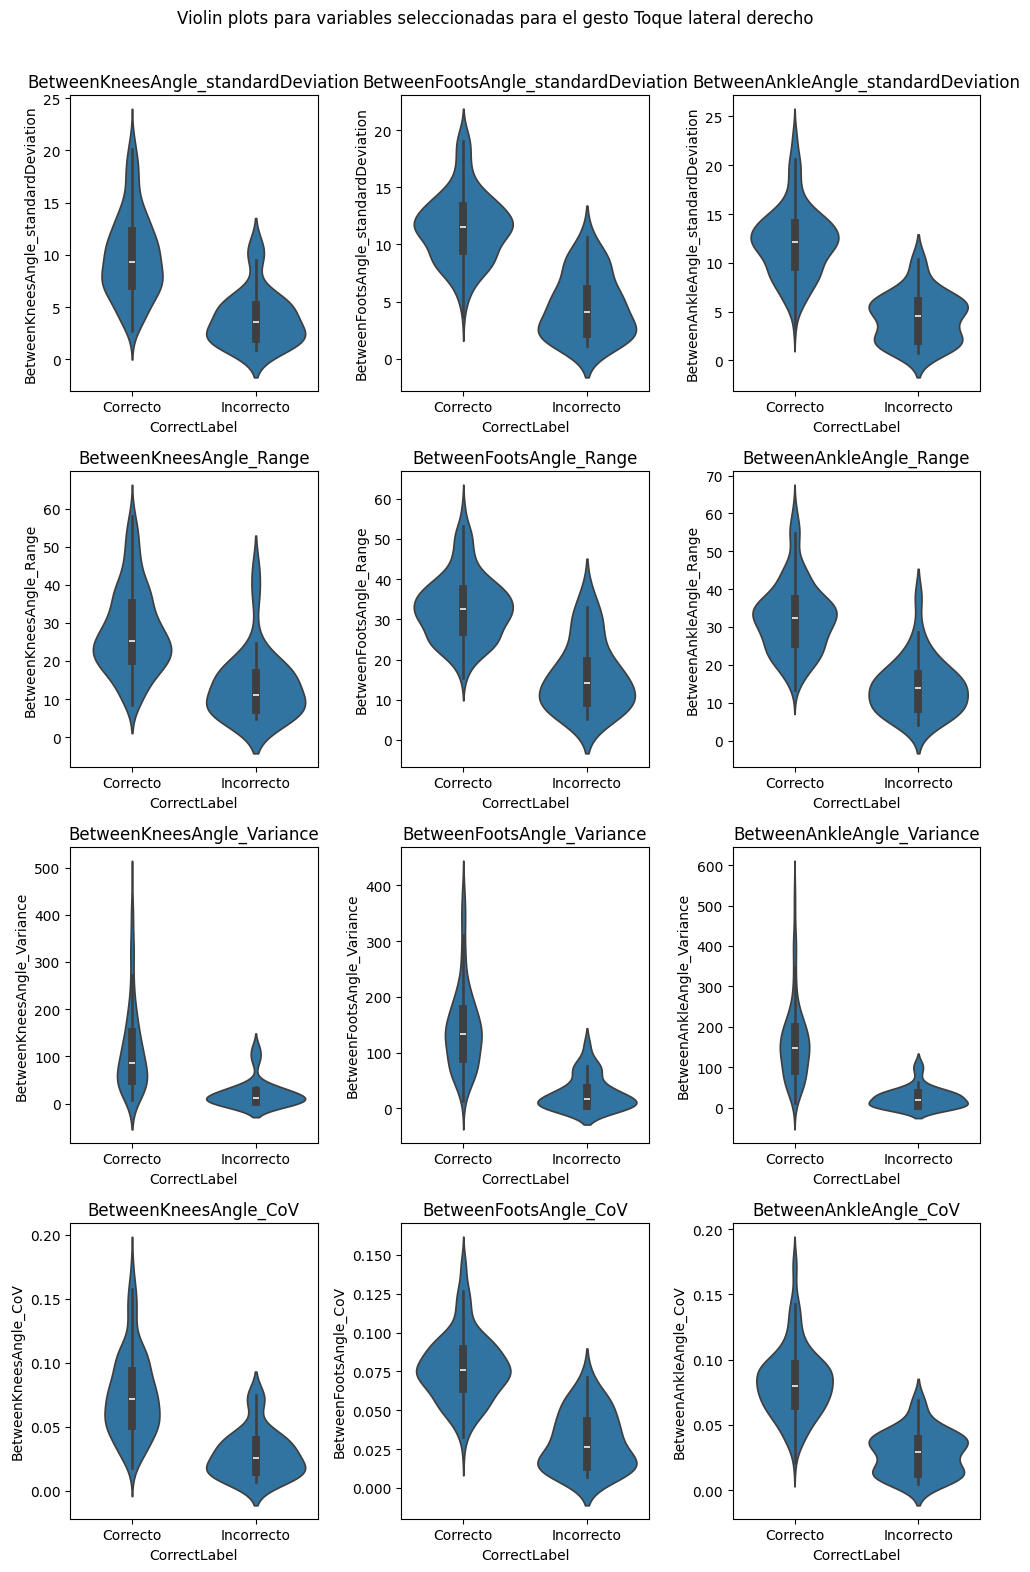

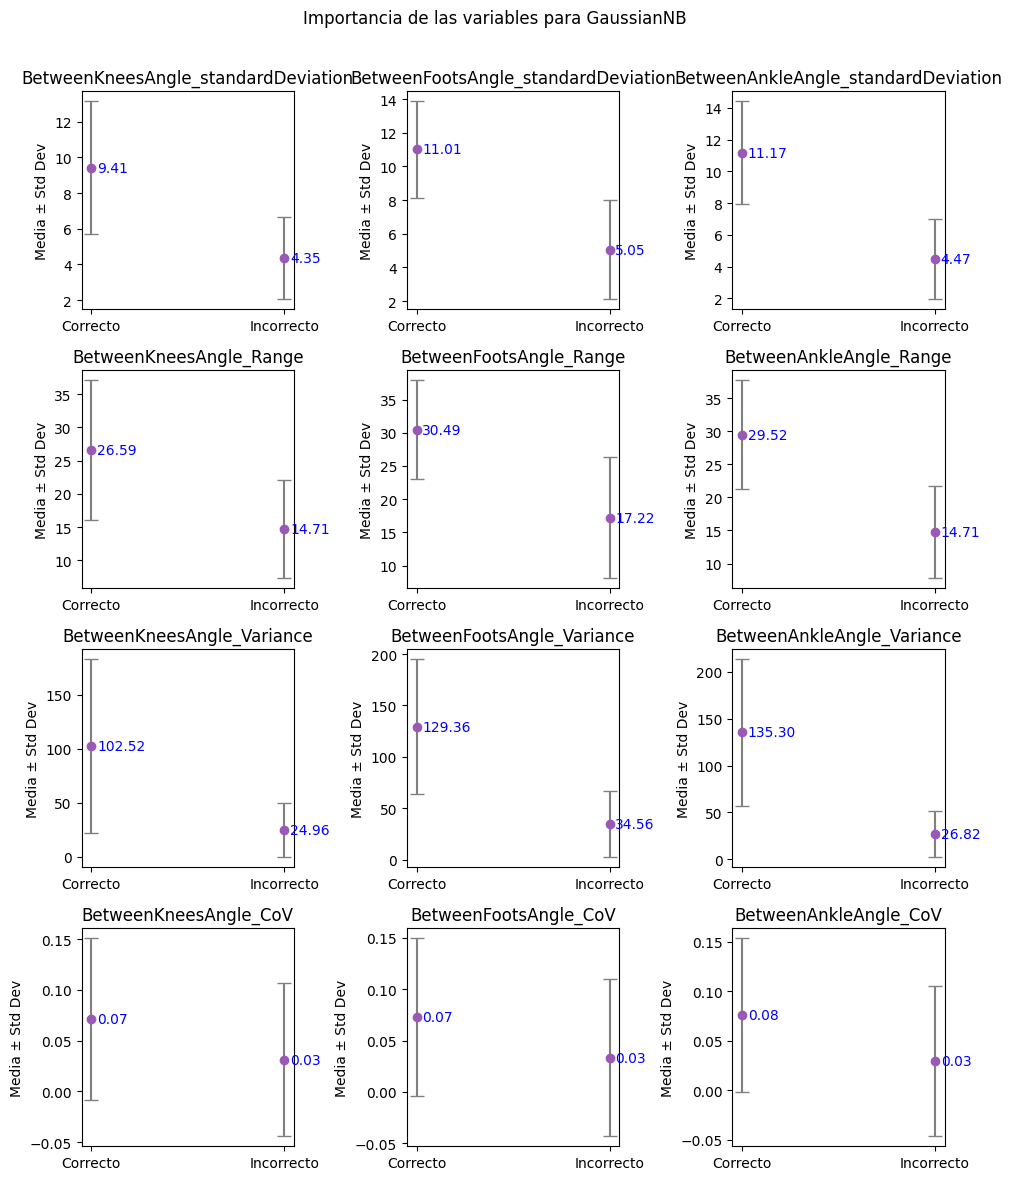

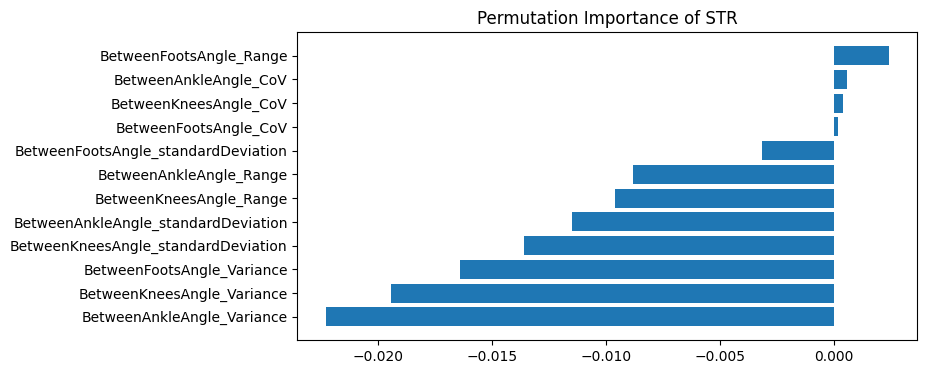

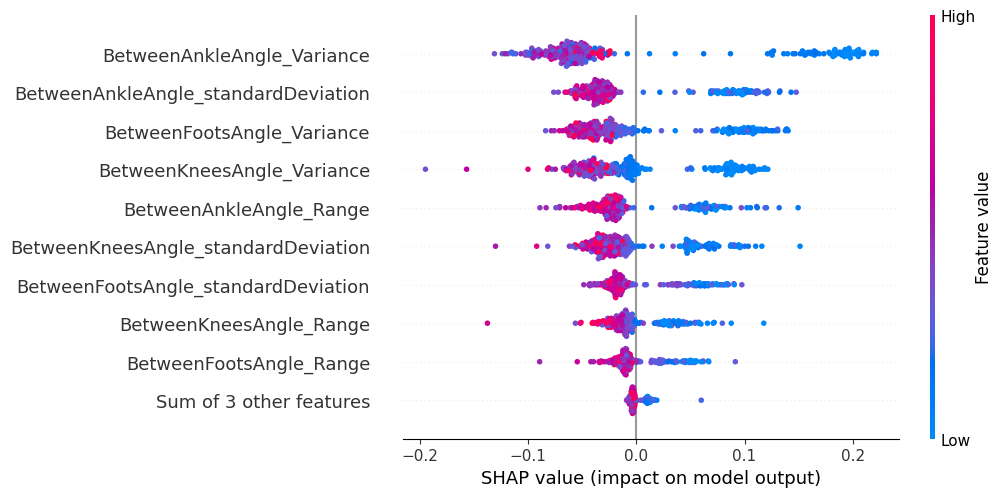

In [5]:
gestures = df_raw['GestureName'].unique()
logo = LeaveOneGroupOut()
results = []
gesture_name_mapping = {
    'EFL': 'Flexión del codo izquierdo',
    'EFR': 'Flexión del codo derecho',
    'SFL': 'Flexión del hombro izquierdo',
    'SFR': 'Flexión del hombro derecho',
    'SAL': 'Abducción del hombro izquierdo',
    'SAR': 'Abducción del hombro derecho',
    'SFE': 'Elevación frontal del hombro',
    'STL': 'Toque lateral izquierdo',
    'STR': 'Toque lateral derecho'
}

for gesture in gestures:
    df_gesture = df_raw[df_raw['GestureName'] == gesture]
    gesture_name = gesture_name_mapping.get(gesture)

    # ------ 1. Caracterización de movimientos ------ 
    # Cálculo de ángulos según gesto
    df_calculations = fn.apply_angles_II(df_gesture, gesture)
    #  Cálculos estadísticos para agrupar por repeticion 
    df_stats = fn.calculos_estadisticos(df_calculations)

    columnas = ['standardDeviation', 'Maximum', 'Minimum', 'Mean', 'Range',
                    'Variance', 'CoV', 'Skewness', 'Kurtosis']
    nuevas_columnas = pd.concat([fn.formatear_columnas(df_stats[col], col)
                                 for col in columnas], axis=1)
    df_stats = pd.concat([df_stats, nuevas_columnas], axis=1)
    df_stats = df_stats.drop(columnas, axis=1)

    # cambiar las poorly executed to incorrectly executed
    df_stats.loc[df_stats['CorrectLabel'] == 3, 'CorrectLabel'] = 2

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = split_df_gestures(df_stats, 'CorrectLabel')
    print(f'\n------------ CLASIFICACION GESTO {gesture} ({gesture_name}) -----------\n')

    #  ------ 2. Crear el pipeline ------ 
    pipeline = ImbPipeline([
        ('balance_data', SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))),
        ('select_features', SelectKBest(score_func=f_classif)),
        ('classifier', KNeighborsClassifier(n_neighbors=2))
    ])
    
    # mejores hiperparámetros
    random = RandomizedSearchCV(pipeline, param_grid, cv=logo, n_jobs=-1, n_iter=15, scoring='roc_auc')
    random.fit(X_train, y_train, groups=X_train['SubjectID'])
    
    # Mejor pipeline encontrado
    best_pipeline = random.best_estimator_
    print(best_pipeline)

    # ------  3. Evaluar el modelo ------ 
    f1_score_train = best_pipeline.score(X_train, y_train)
    f1_score_test = best_pipeline.score(X_test, y_test)
    print(f'F1-score del conjunto de entrenamiento: {f1_score_train}')
    prediction = best_pipeline.predict(X_test)
    print("Informe de clasificación (conjunto de prueba):")
    print(classification_report(y_test, prediction)) 
    
    # Calcular la curva ROC
    y_prob = best_pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=2)
    roc_auc = auc(fpr, tpr)
    
    # Graficar la curva ROC
    plt.figure(figsize=(4, 3))  
    plt.plot(fpr, tpr, label=f'Curva ROC (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'Curva ROC (gesto {gesture})')
    plt.legend()
    plt.show()

    # Matriz de confusión
    prediction = best_pipeline.predict(X_test)
    cm = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(cm, index=['correcto', 'incorrecto'], columns=['correcto', 'incorrecto'])
    plt.figure(figsize=(3, 2))
    ax = sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
    ax.set_title(f'Matriz de confusión de {gesture}')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    plt.show()

    # ------  4. Explicación global ------ 
    # Variables seleccionadas
    feature_names = X_train.columns
    select_kbest = best_pipeline.named_steps['select_features']
    selected_features_mask = select_kbest.get_support()
    selected_features = feature_names[selected_features_mask]

    df_selected = df_stats[selected_features]
  
    y = df_stats['CorrectLabel'] 
    y_mapped = y.map({1: 'Correcto', 2: 'Incorrecto'})

    # Violin plots
    n_features = len(selected_features)
    n_cols = 3  
    n_rows = (n_features + n_cols - 1) // n_cols 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4*n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(selected_features):
        sns.violinplot(x=y_mapped, y=df_selected[feature], ax=axes[i])
        axes[i].set_title(f'{feature}') 
        axes[i].set_xlabel('CorrectLabel')
        axes[i].set_ylabel(feature)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f'Violin plots para variables seleccionadas para el gesto {gesture_name}')
    plt.tight_layout(rect=[0, 0, 1, 0.97]) 
    plt.show()

    # Visualizar los clasificadores
    classifier = best_pipeline.named_steps['classifier']
    classifier_name = classifier.__class__.__name__

    if classifier_name == 'GaussianNB':

        means = classifier.theta_
        variances = classifier.var_

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
        axes = axes.flatten()
    
        for i, feature in enumerate(selected_features):
            axes[i].errorbar([0, 1], means[:, i], yerr=np.sqrt(variances[:, i]),
                             fmt='o', capsize=5, color='#9b59b6', ecolor='gray')
            for j in range(2):  
                axes[i].text(j+0.03, means[j, i], f'{means[j, i]:.2f}', 
                     ha='left', va='center', fontsize=10, color='blue')
            axes[i].set_title(f'{feature}')
            axes[i].set_xticks([0, 1])
            axes[i].set_xticklabels(['Correcto', 'Incorrecto'])
            axes[i].set_ylabel('Media ± Std Dev')

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

    elif classifier_name == 'DecisionTreeClassifier':
        fig = plt.figure(figsize=(8, 6), dpi=300) 
        tree.plot_tree(classifier,
                        feature_names=selected_features,
                        class_names=np.unique(y_mapped.values).astype(str),
                        filled=True)

    elif classifier_name == 'LogisticRegression':
        coefficients = classifier.coef_[0]
        plt.figure(figsize=(10, 6))
        plt.barh(selected_features, coefficients)
        plt.xlabel("Valor del coeficiente")
        plt.title("Importancia de las características en la regresión logística")
        plt.axvline(x=0, color="grey", linestyle="--")
      
    elif classifier_name == 'RandomForestClassifier':
        fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,5), dpi=900)
        for index in range(0, 5):
            tree.plot_tree(classifier.estimators_[index],
                        feature_names=selected_features, 
                        class_names=np.unique(y_mapped.values).astype(str),
                        filled = True,
                        ax = axes[index])
        axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
        plt.tight_layout()

    elif classifier_name == 'SVC' and classifier.kernel == 'linear':
        weights = classifier.coef_[0]
        plt.figure(figsize=(10, 6))
        plt.barh(selected_features, weights, color='blue')
        plt.axvline(x=0, color='grey', linestyle='--')
        plt.xlabel("Valor del peso (Importancia de la característica)")
        plt.title("Importancia de las características en el clasificador SVC")

    fig.suptitle(f'Importancia de las variables para {classifier_name}')
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # para que el titulo se vea bien
    plt.show()

    # Permutation Importance
    perm_importance = permutation_importance(classifier, df_selected, y, scoring='f1',n_repeats=10)
    sorted_idx = perm_importance.importances_mean.argsort()
    fig = plt.figure(figsize=(8, 4))
    plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(df_selected.columns)[sorted_idx])
    plt.title(f'Permutation Importance of {gesture}')
    plt.show()

    #SHAP
    explainer = shap.Explainer(classifier.predict, df_selected)
    shap_values = explainer(df_selected)
    shap.plots.beeswarm(shap_values)

    # Guardar resultados evaluacion
    results.append({
        'Gesto': gesture,
        'Nombre': gesture_name,
        'Classifier': classifier_name,
        'K': select_kbest.k,
        'F1-score train': f1_score_train,
        'F1-score test': f1_score_test,
        'AUC': roc_auc
    })

    # ------ Guardar el pipeline entrenado --------
    filename = f'../Resultados/modelo_{gesture}.sav'
    joblib.dump(best_pipeline, filename)

***• Resumen resultados***

In [6]:
df_results = pd.DataFrame(results)
df_results

Gesto                          Nombre     Classifier   K  F1-score train  \
0   EFL      Flexión del codo izquierdo            SVC   5        0.883598   
1   EFR        Flexión del codo derecho  MLPClassifier   7        0.895288   
2   SFL    Flexión del hombro izquierdo            SVC  13        0.888476   
3   SFR      Flexión del hombro derecho     GaussianNB  12        0.806723   
4   SAL  Abducción del hombro izquierdo  MLPClassifier  12        0.775862   
5   SAR    Abducción del hombro derecho  MLPClassifier  11        0.819149   
6   SFE    Elevación frontal del hombro  MLPClassifier   5        0.969231   
7   STL         Toque lateral izquierdo  MLPClassifier   5        0.885870   
8   STR           Toque lateral derecho     GaussianNB  12        0.806283   

   F1-score test       AUC  
0       0.827586  0.896359  
1       0.907895  0.863248  
2       0.688889  0.817194  
3       0.793651  0.969767  
4       0.629213  0.707246  
5       0.836735  0.838415  
6       0.901961  0.943902  
7       0.969231  0.978070  
8       0.966292  1.000000

In [7]:
print(f'El F1-score medio es: {df_results["F1-score test"].mean()}')
print(f'\nEl AUC medio es: {df_results["AUC"].mean()}')

El F1-score medio es: 0.8357169435197682

El AUC medio es: 0.890466794426216
